### Packages

In [ ]:
import pandas as pd
import numpy as np
import time

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # Create TD / TF-IDF Matricies
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression # Preform Logistic Regression
from sklearn.metrics import confusion_matrix # Make the Confustion Matrix
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score # for AUC, fpr, tpr, threshold and accuracy
from sklearn.metrics import precision_recall_fscore_support
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from nltk.corpus import stopwords # for the Stopwords list
from nltk.stem import PorterStemmer # for the porter Stemmer
import nltk # for other nltk functions
import re # for regular expression functions

from tqdm import tqdm  # for progress bar
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...

[nltk_data]   Unzipping tokenizers/punkt.zip.

[nltk_data] Downloading package stopwords to /root/nltk_data...

[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!pip install optuna
import optuna



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 4.4 MB/s eta 0:00:00



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 6.8 MB/s eta 0:00:00










     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.0 MB/s eta 0:00:00







### Removing Columns and Missing Data

In [ ]:
# Read in data
job_postings = pd.read_csv("../postings.csv")

# Subsetting For Job Description and Experience Level
want =  ["description","formatted_experience_level"]
df = job_postings[want]
# Dropping Missing Values
df = df.dropna(subset=['formatted_experience_level']).reset_index(drop=True)

In [ ]:
df['description'] = df['description'].astype(str)
df["formatted_experience_level"] = np.where(df["formatted_experience_level"] == 'Entry level',1,0)

## Modeling Using Specific Features

### Feature Engineering

In [ ]:
def Features(df, column_name):
    feature_columns = ['word_cnt', 'sent_cnt', 'vocab_cnt', 'Avg_sent_word_cnt', 'lexical_richness','Readability_index']
    feature_data = []

    for index, row in df.iterrows():
        text = row[column_name]

        # Simple features (Word Count, Sentance Count, Vocabulary Count, Lexical Diversity)
        tokens = nltk.word_tokenize(text)
        char_cnt = len(tokens)

        words = [w for w in tokens if w.isalpha()]
        word_cnt = len(words)

        avg_word_length = char_cnt/word_cnt

        sents = nltk.sent_tokenize(text)
        sent_cnt = len(sents)

        avg_sent_length = word_cnt / sent_cnt if sent_cnt > 0 else 0
        avg_sent_length = round(avg_sent_length,2)

        vocab = set(words)
        vocab_cnt = len(vocab)

        lex_richness = round(vocab_cnt / word_cnt, 4)

        ARI = 4.71*avg_word_length + .5*avg_sent_length - 21.43

        # Append the column data
        feature_data.append([word_cnt, sent_cnt, vocab_cnt, avg_sent_length, lex_richness ,ARI]) # dropped avg_sent_length

    feature_df = pd.DataFrame(feature_data, columns=feature_columns)

    # Combine the original DataFrame with the new DataFrame containing features
    result_df = pd.concat([df, feature_df], axis=1)

    return result_df


### PreProcessing for Feature Engineered Data

Training and Testing Sets

In [ ]:
FE_df = Features(df,'description')

In [ ]:
FE_df['Cust_Service'] = FE_df['description'].apply(lambda x: 1 if 'customer service' in x.lower() else 0)
FE_df['diploma_ged'] = FE_df['description'].apply(lambda x: 1 if 'diploma ged' in x.lower() else 0)
FE_df['per_hour'] = FE_df['description'].apply(lambda x: 1 if 'per hour' in x.lower() else 0)
FE_df['diploma_equiv'] = FE_df['description'].apply(lambda x: 1 if 'diploma equivalent' in x.lower() else 0)
FE_df['project_management'] = FE_df['description'].apply(lambda x: 1 if 'project management' in x.lower() else 0)
FE_df['cross_functional'] = FE_df['description'].apply(lambda x: 1 if 'cross functional' in x.lower() else 0)
FE_df['minimum_years'] = FE_df['description'].apply(lambda x: 1 if 'minimum years' in x.lower() else 0)
FE_df['experience_working'] = FE_df['description'].apply(lambda x: 1 if 'experience working' in x.lower() else 0)
FE_df['management'] = FE_df['description'].apply(lambda x: 1 if 'management ' in x.lower() else 0)
FE_df['track_record'] = FE_df['description'].apply(lambda x: 1 if 'track_record ' in x.lower() else 0)

In [ ]:
x_fe = FE_df.drop(['description', 'formatted_experience_level'], axis=1)
y_fe = FE_df['formatted_experience_level']

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(x_fe, y_fe, test_size = 0.2, random_state = 1)

In [ ]:
X_train2.head()

,word_cnt,sent_cnt,vocab_cnt,Avg_sent_word_cnt,lexical_richness,Readability_index,Cust_Service,diploma_ged,per_hour,diploma_equiv,project_management,cross_functional,minimum_years,experience_working,management,track_record
1172,298,2,169,149.00,0.5671,58.601879,0,0,0,0,0,0,0,0,0,0
1163,128,4,90,32.00,0.7031,0.310313,0,0,0,0,0,0,0,0,0,0
10908,764,29,430,26.34,0.5628,-2.575942,0,0,0,0,0,0,0,0,0,0
385,799,39,450,20.49,0.5632,-5.602559,0,0,0,0,0,0,0,0,1,0
5086,1178,52,583,22.65,0.4949,-4.539363,0,0,0,0,0,0,1,0,1,0


Resampling for imbalence

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train2, y_train2)

Normalizing the Data

In [ ]:
scaler = MinMaxScaler()
X_train_resampled_normalized = scaler.fit_transform(X_train_resampled)
X_test2_normalized = scaler.transform(X_test2)

X_train_resampled_normalized = pd.DataFrame(X_train_resampled_normalized, columns=X_train2.columns)
X_test2_normalized = pd.DataFrame(X_test2_normalized, columns=X_test2.columns)

### Logistic Regression



10-fold Training

In [ ]:
def objective(trial):

    C_value = trial.suggest_float('C', 1e-4, 1e3, log=True)  # Log-uniform distribution for C

    logistic_fe = LogisticRegression(C=C_value, penalty='l1', solver='liblinear', max_iter=1000)
    logistic_fe_cv_scores = cross_val_score(logistic_fe, X_train_resampled_normalized, y_train_resampled, cv=10, scoring='accuracy')

    return logistic_fe_cv_scores.mean()


In [ ]:
start_time = time.time() # record time
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
end_time = time.time() # record time
#Computing Training Duration
logistic_fe_tt = end_time - start_time

[I 2023-12-11 00:45:50,376] A new study created in memory with name: no-name-fed0007d-47aa-457e-86f7-a4a56d43683f

[I 2023-12-11 00:46:54,748] Trial 0 finished with value: 0.6468478184315243 and parameters: {'C': 182.95524702439866}. Best is trial 0 with value: 0.6468478184315243.

[I 2023-12-11 00:46:59,289] Trial 1 finished with value: 0.6372530549001655 and parameters: {'C': 0.5105719549012369}. Best is trial 0 with value: 0.6468478184315243.

[I 2023-12-11 00:46:59,579] Trial 2 finished with value: 0.5 and parameters: {'C': 0.0007754358724072872}. Best is trial 0 with value: 0.6468478184315243.

[I 2023-12-11 00:48:01,408] Trial 3 finished with value: 0.646933508234438 and parameters: {'C': 149.74765900095284}. Best is trial 3 with value: 0.646933508234438.

[I 2023-12-11 00:48:02,039] Trial 4 finished with value: 0.6318543038583888 and parameters: {'C': 0.05931417785077016}. Best is trial 3 with value: 0.646933508234438.

[I 2023-12-11 00:48:57,331] Trial 5 finished with value: 0.

In [ ]:
print(f"Train Time: {logistic_fe_tt} Seconds")

best_params = study.best_params
print(f"Best Hyperparameters: {best_params}")

mean_acc_lfe = study.best_value
print(f"Best 10-Fold CV Accuracy: {mean_acc_lfe:.2%}")

Train Time: 246.42279410362244 Seconds

Best Hyperparameters: {'C': 23.218791242680226}

Best 10-Fold CV Accuracy: 64.85%


Predicting on Test Set

In [ ]:
logistic_fe = LogisticRegression(C=best_params['C'], penalty='l1', solver='liblinear', max_iter=1000)
logistic_fe.fit(X_train_resampled_normalized, y_train_resampled)

# Predict on train and test datasets
y_test_pred_lfe = logistic_fe.predict(X_test2_normalized)

#Test Accuracy
test_acc_lfe = accuracy_score(y_test2, y_test_pred_lfe)
print(f"Test Accuracy: {test_acc_lfe:.2%}")

Test Accuracy: 63.22%


In [ ]:
print("Coefficient Weights on Test Data:")
coef_weights_test = logistic_fe.coef_
for feature, coef in zip(X_train_resampled_normalized.columns, coef_weights_test.flatten()):
    print(f"{feature}: {coef:.4f}")

Coefficient Weights on Test Data:

word_cnt: -6.6305

sent_cnt: 5.5338

vocab_cnt: 4.0810

Avg_sent_word_cnt: 112.2883

lexical_richness: 0.5961

Readability_index: -117.2655

Cust_Service: 0.7273

diploma_ged: 0.0000

per_hour: 1.2360

diploma_equiv: 0.0000

project_management: -0.4419

cross_functional: -0.8865

minimum_years: 0.7516

experience_working: -0.2310

management: -0.6845

track_record: 0.0000


In [ ]:
# Compute test probabilities, false positive rate, true positive rate, and auc
y_test_prob_lfe = logistic_fe.predict_proba(X_test2_normalized)[:, 1]  # Probability of class 1 (positive)
fpr_lfe, tpr_lfe, threshold_lfe = roc_curve(y_test2,y_test_prob_lfe)
auc_score_lfe = roc_auc_score(y_test2, y_test_prob_lfe)
precision_lfe, recall_lfe, f1_lfe, _ = precision_recall_fscore_support(y_test2, y_test_pred_lfe)
print(f"AUC Score: {auc_score_lfe:.2%}")
print(f"Precision: {precision_lfe[1]:.2%}")
print(f"Recall: {recall_lfe[1]:.2%}")
print(f"F1-Score: {f1_lfe[1]:.2%}")

AUC Score: 69.33%

Precision: 46.90%

Recall: 66.08%

F1-Score: 54.86%


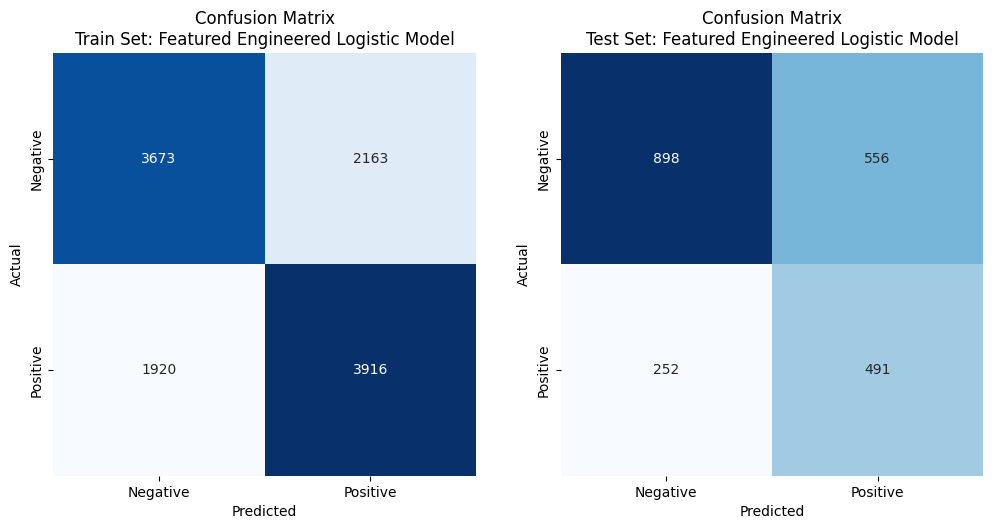

In [ ]:
# Compute confusion matrices
y_train_pred_lfe = logistic_fe.predict(X_train_resampled_normalized)
conf_matrix_train_lfe = confusion_matrix(y_train_resampled, y_train_pred_lfe)
conf_matrix_test_lfe = confusion_matrix(y_test2, y_test_pred_lfe)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# First heatmap for Train Set
sns.heatmap(conf_matrix_train_lfe, annot=True, fmt='d', cmap='Blues', square=True,cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=[ 'Negative','Positive'], ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix\nTrain Set: Featured Engineered Logistic Model')

# Second heatmap for Test Set
sns.heatmap(conf_matrix_test_lfe, annot=True, fmt='d', cmap='Blues', square=True,cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=[ 'Negative','Positive'], ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix\nTest Set: Featured Engineered Logistic Model');

### Naive Bayes


Training the Bayes Model with 10-Fold CV

In [ ]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

start_time = time.time()
# Fitting the Naive Bayes model
bayes_fe = GaussianNB()
# Preforming 10-Fold CV
bayes_fe_10fold = cross_val_score(bayes_fe,X_train_resampled_normalized, y_train_resampled, cv=10)
end_time = time.time()
# Computing Train Time
bayes_fe_tt = end_time - start_time
print(f"Training Duration: {bayes_fe_tt} Seconds")

mean_acc_bfe = bayes_fe_10fold.mean()
print(f"10-Fold Cross-Validation Accuracy: {mean_acc_bfe}")

Training Duration: 0.15372896194458008 Seconds

10-Fold Cross-Validation Accuracy: 0.6169451585261354


Predicting on Test Set

In [ ]:
bayes_fe.fit(X_train_resampled_normalized, y_train_resampled)
# Predict on train and test datasets
y_test_pred_bfe = bayes_fe.predict(X_test2_normalized)

#Test Accuracy
test_acc_bfe = accuracy_score(y_test2, y_test_pred_bfe)
print(f"Test Accuracy: {test_acc_bfe:.2%}")

Test Accuracy: 56.62%


In [ ]:
# Compute test probabilities, false positive rate, true positive rate, and auc
y_test_prob_bfe = bayes_fe.predict_proba(X_test2_normalized)[:, 1]  # Probability of class 1 (positive)
fpr_bfe, tpr_bfe, threshold_bfe = roc_curve(y_test2,y_test_prob_bfe)
auc_score_bfe = roc_auc_score(y_test2, y_test_prob_bfe)
precision_bfe, recall_bfe, f1_bfe, _ = precision_recall_fscore_support(y_test2, y_test_pred_bfe)
print(f"AUC Score: {auc_score_bfe:.2%}")
print(f"Precision: {precision_bfe[1]:.2%}")
print(f"Recall: {recall_bfe[1]:.2%}")
print(f"F1-Score: {f1_bfe[1]:.2%}")


AUC Score: 68.19%

Precision: 42.53%

Recall: 80.48%

F1-Score: 55.65%


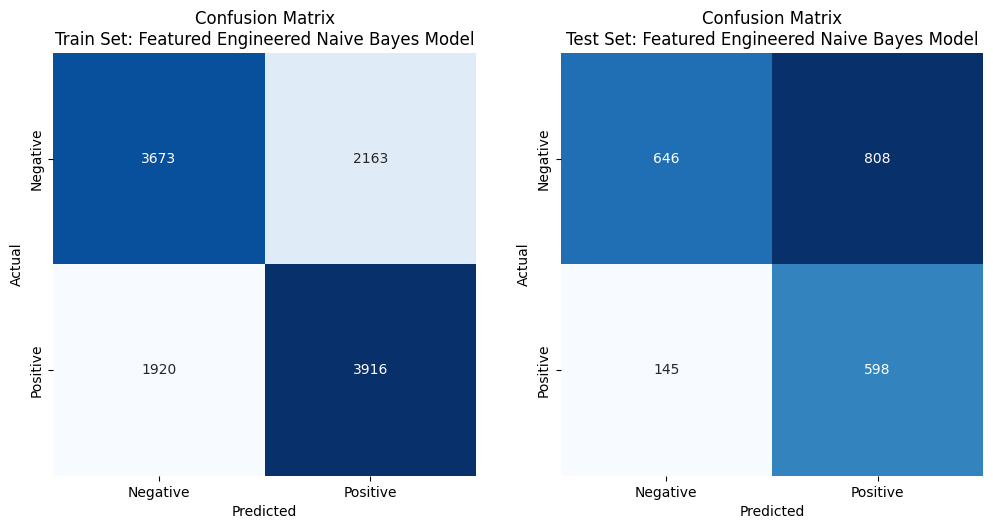

In [ ]:
# Compute confusion matrices
y_train_pred_bfe = logistic_fe.predict(X_train_resampled_normalized)
conf_matrix_train_bfe = confusion_matrix(y_train_resampled, y_train_pred_bfe)
conf_matrix_test_bfe = confusion_matrix(y_test2, y_test_pred_bfe)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# First heatmap for Train Set
sns.heatmap(conf_matrix_train_bfe, annot=True, fmt='d', cmap='Blues', square=True,cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=[ 'Negative','Positive'], ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix\nTrain Set: Featured Engineered Naive Bayes Model')

# Second heatmap for Test Set
sns.heatmap(conf_matrix_test_bfe, annot=True, fmt='d', cmap='Blues', square=True,cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=[ 'Negative','Positive'], ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix\nTest Set: Featured Engineered Naive Bayes Model');

### KNN


In [ ]:
k_values = list(range(1, 20))
cv_scores_fe = []

start_time_knn = time.time()

for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_model, X_train_resampled_normalized, y_train_resampled, cv=10)
    cv_scores_fe.append(scores.mean())

end_time_knn = time.time()
knn_tt_fe1 = end_time_knn - start_time_knn

K vs Accuracy Curve: looking for the k that minimizes error


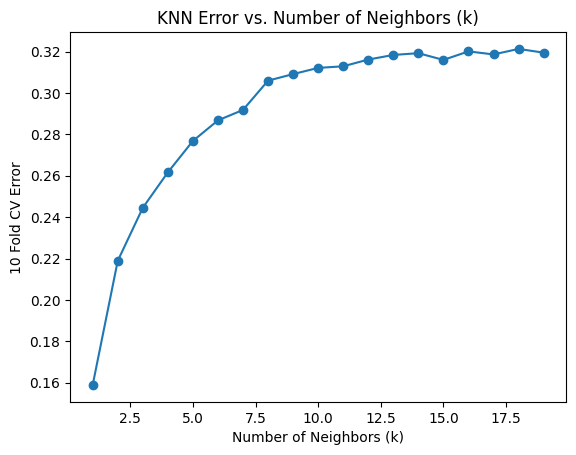

Optimal K: 1


In [ ]:
errors_fe = [(1-i) for i in cv_scores_fe]

figsize=(12, 6)
plt.plot(k_values, errors_fe, marker='o')
plt.title('KNN Error vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('10 Fold CV Error')
plt.show()

# Find the optimal k with the highest accuracy
optimal_k_fe = k_values[errors_fe.index(min(errors_fe))]
print(f"Optimal K: {optimal_k_fe}")

In [ ]:
knn_fe = KNeighborsClassifier(n_neighbors=optimal_k_fe)
start_time_knn = time.time()
knn_10fold_fe = cross_val_score(knn_fe, X_train_resampled_normalized, y_train_resampled, cv=10)
knn_fe.fit(X_train_resampled_normalized, y_train_resampled)
end_time_knn = time.time()

# Computing Training Duration
knn_tt_fe = (end_time_knn - start_time_knn) + knn_tt_fe1
print(f"Training Duration: {knn_tt_fe} Seconds")

mean_acc_knnfe = knn_10fold_fe.mean()
print(f"10-Fold Cross-Validation Accuracy: {mean_acc_knnfe:.2%}")

Training Duration: 33.541712284088135 Seconds

10-Fold Cross-Validation Accuracy: 84.11%


In [ ]:
# Predict on train and test datasets
y_test_pred_knn_fe = knn_fe.predict(X_test2_normalized)

# Test Accuracy
test_acc_knn_fe = accuracy_score(y_test2, y_test_pred_knn_fe)
print(f"Test Accuracy: {test_acc_knn_fe:.2%}")

# Compute test probabilities, false positive rate, true positive rate, and auc
y_test_prob_knn_fe = knn_fe.predict_proba(X_test2_normalized)[:, 1]  # Probability of class 1 (positive)
fpr_knn_fe, tpr_knn_fe, threshold_knn_fe = roc_curve(y_test2, y_test_prob_knn_fe)
auc_score_knn_fe = roc_auc_score(y_test2, y_test_prob_knn_fe)
precision_knn_fe, recall_knn_fe, f1_knn_fe, _ = precision_recall_fscore_support(y_test2, y_test_pred_knn_fe)
print(f"AUC Score: {auc_score_knn_fe:.2%}")
print(f"Precision: {precision_knn_fe[1]:.2%}")
print(f"Recall: {recall_knn_fe[1]:.2%}")
print(f"F1-Score: {f1_knn_fe[1]:.2%}")

Test Accuracy: 69.87%

AUC Score: 66.28%

Precision: 55.48%

Recall: 55.18%

F1-Score: 55.33%


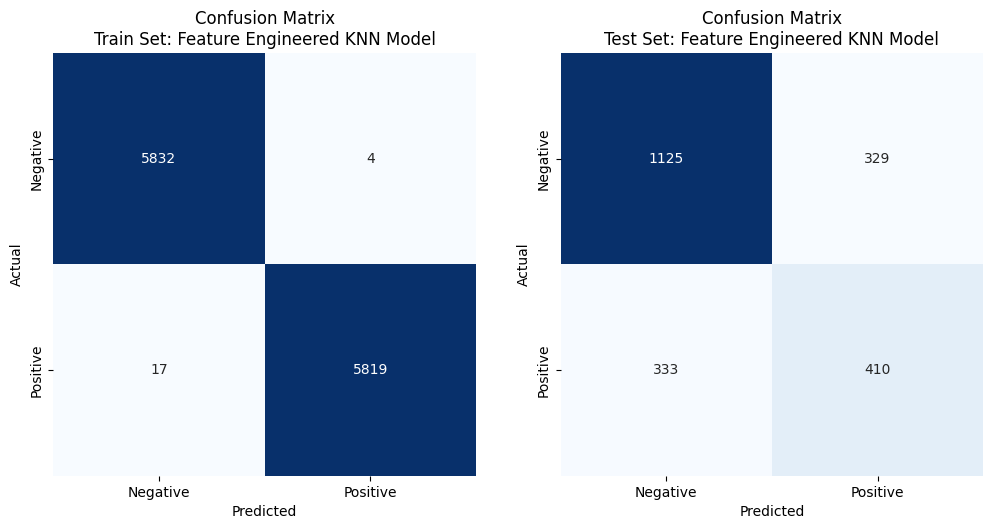

In [ ]:
# Compute confusion matrices
y_train_pred_knn_fe = knn_fe.predict(X_train_resampled_normalized)
conf_matrix_train_knn_fe = confusion_matrix(y_train_resampled, y_train_pred_knn_fe)
conf_matrix_test_knn_fe = confusion_matrix(y_test2, y_test_pred_knn_fe)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# First heatmap for Train Set
sns.heatmap(conf_matrix_train_knn_fe, annot=True, fmt='d', cmap='Blues', square=True, cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix\nTrain Set: Feature Engineered KNN Model')

# Second heatmap for Test Set
sns.heatmap(conf_matrix_test_knn_fe, annot=True, fmt='d', cmap='Blues', square=True, cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix\nTest Set: Feature Engineered KNN Model')

plt.show()

### Random Forest

Training Random Forest with 10-Fold CV

In [ ]:
def objective(trial):
    param_dist = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_features': trial.suggest_categorical('max_features', ['sqrt',None]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2,20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1,20)
    }

    rf_fe = RandomForestClassifier(criterion='entropy', random_state=42, **param_dist)
    cv_scores = cross_val_score(rf_fe, X_train_resampled_normalized, y_train_resampled, cv=10)

    return cv_scores.mean()

In [ ]:
start_time = time.time() # record time
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective, n_trials=5)
end_time = time.time() # record time

[I 2023-12-11 00:50:39,942] A new study created in memory with name: no-name-6e709ef9-0557-466c-a874-3f7f9cf07d8d

[I 2023-12-11 00:51:49,055] Trial 0 finished with value: 0.7601136710450634 and parameters: {'n_estimators': 113, 'max_features': None, 'min_samples_split': 18, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.7601136710450634.

[I 2023-12-11 00:52:58,027] Trial 1 finished with value: 0.7924136645889824 and parameters: {'n_estimators': 317, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.7924136645889824.

[I 2023-12-11 00:54:04,147] Trial 2 finished with value: 0.7284980220915354 and parameters: {'n_estimators': 383, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 19}. Best is trial 1 with value: 0.7924136645889824.

[I 2023-12-11 00:57:12,242] Trial 3 finished with value: 0.7671394278738364 and parameters: {'n_estimators': 305, 'max_features': None, 'min_samples_split': 4, 'min_samples_leaf'

In [ ]:
#Computing Training Duration
rf_fe_tt = end_time - start_time
print(f"Training Duration: {rf_fe_tt} Seconds")
print("Best Hyperparameters:", study_rf.best_trial.params)
mean_acc_rffe = study_rf.best_value
print(f"10-Fold Cross-Validation Accuracy: {mean_acc_rffe}")

Training Duration: 567.2859830856323 Seconds

Best Hyperparameters: {'n_estimators': 317, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_samples_leaf': 6}

10-Fold Cross-Validation Accuracy: 0.7924136645889824


Predicting on Test Set

In [ ]:
# Best model from hyperparameter tuning
rf_fe = RandomForestClassifier(criterion='entropy', random_state=42, **study_rf.best_trial.params)
rf_fe.fit(X_train_resampled_normalized, y_train_resampled)

# Predict on train and test datasets
y_test_pred_rffe = rf_fe.predict(X_test2_normalized)

#Test Accuracy
test_acc_rffe = accuracy_score(y_test2, y_test_pred_rffe)
print(f"Test Accuracy: {test_acc_rffe:.2%}")

Test Accuracy: 71.92%


In [ ]:
# Compute test probabilities, false positive rate, true positive rate, and auc
y_test_prob_rffe = rf_fe.predict_proba(X_test2_normalized)[:, 1]  # Probability of class 1 (positive)
fpr_rffe, tpr_rffe, threshold_rffe = roc_curve(y_test2, y_test_prob_rffe)
auc_score_rffe = roc_auc_score(y_test2, y_test_prob_rffe)
precision_rffe, recall_rffe, f1_rffe, _ = precision_recall_fscore_support(y_test2, y_test_pred_rffe)
print(f"AUC Score: {auc_score_rffe:.2%}")
print(f"Precision: {precision_rffe[1]:.2%}")
print(f"Recall: {recall_rffe[1]:.2%}")
print(f"F1-Score: {f1_rffe[1]:.2%}")


AUC Score: 77.09%

Precision: 57.93%

Recall: 61.91%

F1-Score: 59.86%


In [ ]:
# Feature Importance
feature_importances = pd.Series(rf_fe.feature_importances_, index=X_train_resampled_normalized.columns)
print("Feature Importance:")
print(feature_importances.sort_values(ascending=False))

Feature Importance:

lexical_richness      0.170264

Readability_index     0.162343

Avg_sent_word_cnt     0.156355

vocab_cnt             0.139233

word_cnt              0.136514

sent_cnt              0.104746

management            0.046748

Cust_Service          0.038179

per_hour              0.016144

project_management    0.014016

experience_working    0.007342

cross_functional      0.006669

minimum_years         0.001446

diploma_ged           0.000000

diploma_equiv         0.000000

track_record          0.000000

dtype: float64


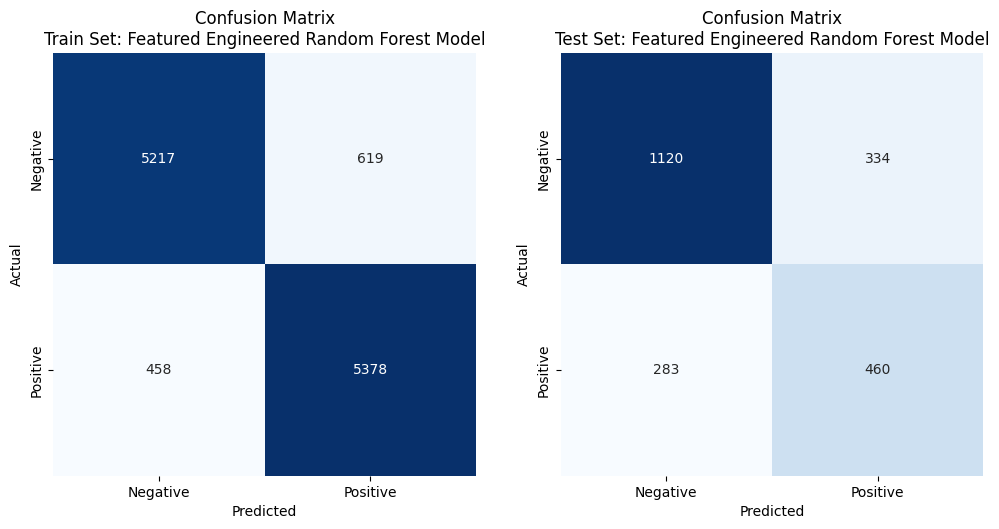

In [ ]:
# Compute confusion matrices
y_train_pred_rffe = rf_fe.predict(X_train_resampled_normalized)
conf_matrix_train_rffe = confusion_matrix(y_train_resampled, y_train_pred_rffe)
conf_matrix_test_rffe = confusion_matrix(y_test2, y_test_pred_rffe)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# First heatmap for Train Set
sns.heatmap(conf_matrix_train_rffe, annot=True, fmt='d', cmap='Blues', square=True,cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=[ 'Negative','Positive'], ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix\nTrain Set: Featured Engineered Random Forest Model')

# Second heatmap for Test Set
sns.heatmap(conf_matrix_test_rffe, annot=True, fmt='d', cmap='Blues', square=True,cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=[ 'Negative','Positive'], ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix\nTest Set: Featured Engineered Random Forest Model');

### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
def objective(trial):
    param_dist = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20)
    }

    gbm = GradientBoostingClassifier(random_state=42, **param_dist)
    cv_scores = cross_val_score(gbm, X_train_resampled_normalized, y_train_resampled, cv=10)

    return cv_scores.mean()

In [ ]:
start_time = time.time()
study_gbm = optuna.create_study(direction='maximize')
study_gbm.optimize(objective, n_trials=10)
end_time = time.time()

[I 2023-12-11 01:00:16,941] A new study created in memory with name: no-name-b7c11374-dc66-4f2c-9f11-ebca2d5f366a

[I 2023-12-11 01:01:37,243] Trial 0 finished with value: 0.8119496190912185 and parameters: {'n_estimators': 344, 'learning_rate': 0.2981780134122269, 'max_depth': 4, 'subsample': 0.7228051569180596, 'min_samples_split': 20, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8119496190912185.

[I 2023-12-11 01:02:58,379] Trial 1 finished with value: 0.8618994377340329 and parameters: {'n_estimators': 177, 'learning_rate': 0.2769832477994221, 'max_depth': 8, 'subsample': 0.7920476718408801, 'min_samples_split': 18, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8618994377340329.

[I 2023-12-11 01:04:08,461] Trial 2 finished with value: 0.7443471141317743 and parameters: {'n_estimators': 313, 'learning_rate': 0.16888375890530277, 'max_depth': 3, 'subsample': 0.9833990517380247, 'min_samples_split': 15, 'min_samples_leaf': 18}. Best is trial 1 with value: 0.86189943

In [ ]:
gbm_fe_tt = end_time - start_time # Tuning Duration
print(f"Training Duration: {gbm_fe_tt} Seconds")
print("Best Hyperparameters:", study_gbm.best_trial.params)
mean_acc_gbmfe = study_gbm.best_value
print(f"10-Fold Cross-Validation Accuracy: {mean_acc_gbmfe}")

Training Duration: 1079.5582888126373 Seconds

Best Hyperparameters: {'n_estimators': 469, 'learning_rate': 0.10312760986569602, 'max_depth': 10, 'subsample': 0.7768534289461673, 'min_samples_split': 18, 'min_samples_leaf': 5}

10-Fold Cross-Validation Accuracy: 0.8717522977779343


In [ ]:
# Best model from hyperparameter tuning
gbm_fe = GradientBoostingClassifier(random_state=42, **study_gbm.best_trial.params)
gbm_fe.fit(X_train_resampled_normalized, y_train_resampled)

In [ ]:
# Computing Test Accuracy Metrics
y_test_pred_gbmfe = gbm_fe.predict(X_test2_normalized)
test_acc_gbmfe = accuracy_score(y_test2, y_test_pred_gbmfe)
print(f"Test Accuracy: {test_acc_gbmfe:.2%}")


y_test_prob_gbmfe = gbm_fe.predict_proba(X_test2_normalized)[:, 1]  # Probability of class 1 (positive)
fpr_gbmfe, tpr_gbmfe, threshold_gbmfe = roc_curve(y_test2, y_test_prob_gbmfe)
auc_score_gbmfe = roc_auc_score(y_test2, y_test_prob_gbmfe)
precision_gbmfe, recall_gbmfe, f1_gbmfe, _ = precision_recall_fscore_support(y_test2, y_test_pred_gbmfe)
print(f"AUC Score: {auc_score_gbmfe:.2%}")
print(f"Precision: {precision_gbmfe[1]:.2%}")
print(f"Recall: {recall_gbmfe[1]:.2%}")
print(f"F1-Score: {f1_gbmfe[1]:.2%}")

Test Accuracy: 73.37%

AUC Score: 76.72%

Precision: 62.34%

Recall: 53.70%

F1-Score: 57.70%


In [ ]:
# Feature Importance
feature_importances_gbmfe = pd.Series(gbm_fe.feature_importances_, index=X_train_resampled_normalized.columns)
print("Feature Importance:")
print(feature_importances_gbmfe.sort_values(ascending=False))

Feature Importance:

lexical_richness      0.223856

Readability_index     0.185552

Avg_sent_word_cnt     0.144701

vocab_cnt             0.137604

word_cnt              0.127855

sent_cnt              0.079789

management            0.037299

Cust_Service          0.032052

project_management    0.010020

per_hour              0.009303

experience_working    0.005582

cross_functional      0.005244

minimum_years         0.001144

diploma_ged           0.000000

diploma_equiv         0.000000

track_record          0.000000

dtype: float64


In [ ]:
# Compute confusion matrices
y_train_pred_gbmfe = gbm_fe.predict(X_train_resampled_normalized)
conf_matrix_train_gbmfe = confusion_matrix(y_train_resampled, y_train_pred_gbmfe)
conf_matrix_test_gbmfe = confusion_matrix(y_test2, y_test_pred_gbmfe)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# First heatmap for Train Set
sns.heatmap(conf_matrix_train_gbmfe, annot=True, fmt='d', cmap='Blues', square=True, cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix\nTrain Set: GBM Feature Engineered')

# Second heatmap for Test Set
sns.heatmap(conf_matrix_test_gbmfe, annot=True, fmt='d', cmap='Blues', square=True, cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix\nTest Set: GBM Feature Engineered');

plt.show();

### Save Feature Engineered the Metrics

In [ ]:
fe_model = ['Logistic','Naive Bayes','Random Forest','GBM','KNN']
features = ['Engineered','Engineered','Engineered','Engineered','Engineered']
fe_trainingtime = [logistic_fe_tt,bayes_fe_tt,rf_fe_tt,gbm_fe_tt, knn_tt_fe]
fe_train_acc = [mean_acc_lfe,mean_acc_bfe,mean_acc_rffe,mean_acc_gbmfe,mean_acc_knnfe]
fe_test_acc = [test_acc_lfe,test_acc_bfe,test_acc_rffe,test_acc_gbmfe,test_acc_knn_fe]

fe_metrics = pd.DataFrame({
    'Model': fe_model,
    'Features': features,
    'Test Accuracy': fe_test_acc,
    'Train Accuracy': fe_train_acc,
    'Training Time': fe_trainingtime
})

with open('fe_metrics.pickle', 'wb') as file:
    pickle.dump(fe_metrics, file)

fe_auc_data = {
    'Logistic-Feature Engineered': {'fpr': fpr_lfe, 'tpr': tpr_lfe, 'auc_score': auc_score_lfe},
    'Naive Bayes-Feature Engineered': {'fpr': fpr_bfe, 'tpr': tpr_bfe, 'auc_score': auc_score_bfe},
    'Random Forest-Feature Engineered': {'fpr': fpr_rffe, 'tpr': tpr_rffe, 'auc_score': auc_score_rffe},
    'GBM-Feature Engineered': {'fpr': fpr_gbmfe, 'tpr': tpr_gbmfe, 'auc_score': auc_score_gbmfe},
    'KNN-Feature Engineered': {'fpr': fpr_knn_fe, 'tpr': tpr_knn_fe, 'auc_score': auc_score_knn_fe}
}

with open('fe_auc_data.pickle', 'wb') as file:
    pickle.dump(fe_auc_data, file)

fe_score_data = {
    'Logistic\nFeature Engineered': {'precision': precision_lfe, 'recall': recall_lfe, 'auc_score': auc_score_lfe, 'F1-Score': f1_lfe},
    'Naive Bayes\nFeature Engineered': {'precision': precision_bfe, 'recall': recall_bfe, 'auc_score': auc_score_bfe, 'F1-Score': f1_bfe},
    'Random Forest\nFeature Engineered': {'precision': precision_rffe, 'recall': recall_rffe, 'auc_score': auc_score_rffe, 'F1-Score': f1_rffe},
    'GBM\nFeature Engineered': {'precision': precision_gbmfe, 'recall': recall_gbmfe, 'auc_score': auc_score_gbmfe, 'F1-Score': f1_gbmfe},
    'KNN\nFeature Engineered': {'precision': precision_knn_fe, 'recall': recall_knn_fe, 'auc_score': auc_score_knn_fe, 'F1-Score': f1_knn_fe}
}

with open('fe_score_data.pickle', 'wb') as file:
    pickle.dump(fe_score_data, file)

## Modeling Using TF-IDF and BOW

### PreProcessing

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
#stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = nltk.word_tokenize(text)
    text = [word.lower() for word in tokens if word.isalpha()]
    text = [word for word in text if word not in stop_words]
    text = [lemmatizer.lemmatize(word) for word in text] # Stemms the word (Porter in this case)
    return ' '.join(text)

[nltk_data] Downloading package wordnet to /root/nltk_data...

[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

Train Test Splits

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [ ]:
# Preprocess the training and testing sets for X and Y
X_train = [preprocess(desc) for desc in X_train.description]
X_test = [preprocess(desc) for desc in X_test.description]

Resampling

Creating Bag-of-Words (Term-Document Matrix) and TF-IDF Matrix

In [ ]:
# Vectorization of text data
vectorizer = CountVectorizer()
X_train_td = vectorizer.fit_transform(X_train)
X_test_td = vectorizer.transform(X_test)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Shape of X_train_vect: ", X_train_tfidf.shape)
print("Shape of X_test_vect: ", X_test_tfidf.shape)

print("Vocabulary Size: ", len(tfidf_vectorizer.vocabulary_))


Shape of X_train_vect:  (8787, 57308)

Shape of X_test_vect:  (2197, 57308)

Vocabulary Size:  57308


In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_resampled_td, y_train_resampled = ros.fit_resample(X_train_td, y_train)
X_train_resampled_tfidf, y_train_resampled = ros.fit_resample(X_train_tfidf, y_train)

### Logistic Regression BOW

In [ ]:
def objective(trial):

    C_value = trial.suggest_float('C', 1e-4, 1e3, log=True)  # Log-uniform distribution for C

    logistic_td = LogisticRegression(C=C_value, penalty='l1', solver='liblinear', max_iter=1000)
    logistic_td_cv_scores = cross_val_score(logistic_td, X_train_resampled_td , y_train_resampled, cv=10, scoring='accuracy')

    return logistic_td_cv_scores.mean()

In [ ]:
start_time = time.time() # record time
study_ltd = optuna.create_study(direction='maximize')
study_ltd.optimize(objective, n_trials=10)
end_time = time.time() # record time

[I 2023-12-07 19:11:39,811] A new study created in memory with name: no-name-ae5bb2a7-b6f6-4c2a-a771-f6b2222ae10f

[I 2023-12-07 19:11:47,277] Trial 0 finished with value: 0.6428199575072483 and parameters: {'C': 0.0007500724636137179}. Best is trial 0 with value: 0.6428199575072483.

[I 2023-12-07 19:11:54,077] Trial 1 finished with value: 0.6998799755842754 and parameters: {'C': 0.0017816904306236544}. Best is trial 1 with value: 0.6998799755842754.

[I 2023-12-07 19:11:57,086] Trial 2 finished with value: 0.5 and parameters: {'C': 0.00030972752239688187}. Best is trial 1 with value: 0.6998799755842754.

[I 2023-12-07 19:12:44,076] Trial 3 finished with value: 0.8935114918242538 and parameters: {'C': 6.5090097927941}. Best is trial 3 with value: 0.8935114918242538.

[I 2023-12-07 19:12:51,388] Trial 4 finished with value: 0.7637951045298214 and parameters: {'C': 0.015579521671966431}. Best is trial 3 with value: 0.8935114918242538.

[I 2023-12-07 19:12:58,377] Trial 5 finished with v

In [ ]:
# Computing Training Duration
logistic_td_tt = end_time - start_time
print(f"Train Time: {logistic_td_tt} Seconds")

best_params_ltd = study_ltd.best_trial.params
print(f"Best Hyperparameters: {best_params_ltd}")

mean_acc_ltd = study_ltd.best_value
print(f"Best 10-Fold CV Accuracy: {mean_acc_ltd:.2%}")

Train Time: 216.2692892551422 Seconds

Best Hyperparameters: {'C': 6.348354989846704}

Best 10-Fold CV Accuracy: 89.48%


In [ ]:
logistic_td = LogisticRegression(C=best_params_ltd['C'], penalty='l1', solver='liblinear', max_iter=1000)
logistic_td.fit(X_train_resampled_td, y_train_resampled)

# Predict on train and test datasets
y_test_pred_ltd = logistic_td.predict(X_test_td)

#Test Accuracy
test_acc_ltd = accuracy_score(y_test, y_test_pred_ltd)
print(f"Test Accuracy: {test_acc_ltd:.2%}")

Test Accuracy: 78.29%


In [ ]:
# Compute test probabilities, false positive rate, true positive rate, and auc
y_test_prob_ltd = logistic_td.predict_proba(X_test_td)[:, 1]  # Probability of class 1 (positive)
fpr_ltd, tpr_ltd, threshold_ltd = roc_curve(y_test,y_test_prob_ltd)
auc_score_ltd = roc_auc_score(y_test, y_test_prob_ltd)
precision_ltd, recall_ltd, f1_ltd, _ = precision_recall_fscore_support(y_test, y_test_pred_ltd)
print(f"AUC Score: {auc_score_ltd:.2%}")
print(f"Precision: {precision_ltd[1]:.2%}")
print(f"Recall: {recall_ltd[1]:.2%}")
print(f"F1-Score: {f1_ltd[1]:.2%}")

AUC Score: 81.87%

Precision: 67.14%

Recall: 70.12%

F1-Score: 68.60%


In [ ]:
# Get the coefficient weights and corresponding features
coef_weights_test_td = logistic_td.coef_.flatten()
features_td = tfidf_vectorizer.get_feature_names_out()

coef_df = pd.DataFrame({'Feature': features_td, 'Coefficient': coef_weights_test_td})
top10_coef_td = coef_df.nlargest(10, 'Coefficient')

# Top 10 features and their coefficient weights
print("Top 10 Coefficient Weights on Test Data:")
print(top10_coef_td)


Top 10 Coefficient Weights on Test Data:

         Feature  Coefficient

45438        sar     6.142339

11926        cut     5.160903

53830     ttuhsc     5.006620

43009        req     4.949643

29596   maryland     4.746743

19834      float     4.596421

54926   valhalla     4.505735

36894     placed     4.385801

13217   deployed     4.228723

11227  craftsman     4.152536


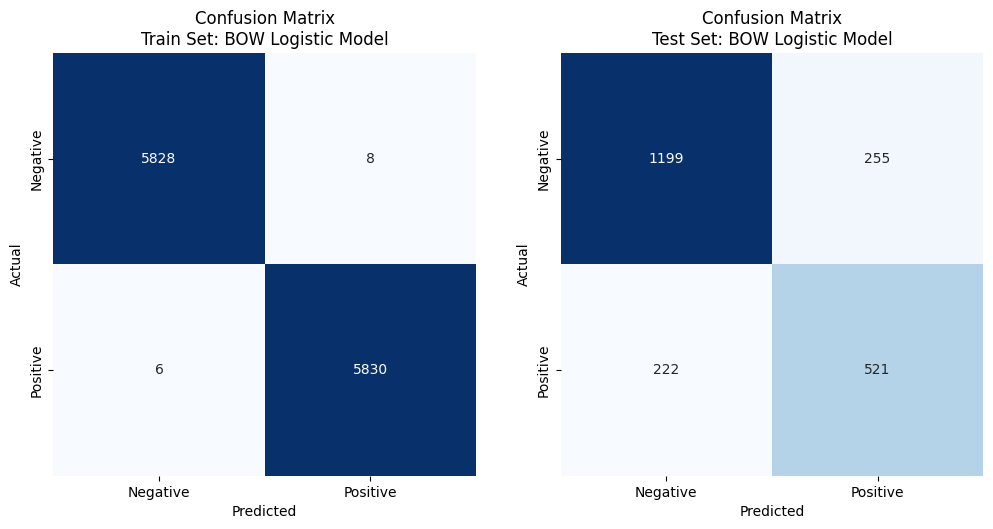

In [ ]:
# Compute confusion matrices
y_train_pred_ltd = logistic_td.predict(X_train_resampled_td)
conf_matrix_train_ltd = confusion_matrix(y_train_resampled, y_train_pred_ltd)
conf_matrix_test_ltd = confusion_matrix(y_test, y_test_pred_ltd)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# First heatmap for Train Set
sns.heatmap(conf_matrix_train_ltd, annot=True, fmt='d', cmap='Blues', square=True,cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix\nTrain Set: BOW Logistic Model')

# Second heatmap for Test Set
sns.heatmap(conf_matrix_test_ltd, annot=True, fmt='d', cmap='Blues', square=True,cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix\nTest Set: BOW Logistic Model');

### Naive Bayes - BOW

10-Fold CV Training

In [ ]:
start_time = time.time()
# Fitting the Naive Bayes model
bayes_td = MultinomialNB()
# Preforming 10-Fold CV
bayes_td_10fold = cross_val_score(bayes_td,X_train_resampled_td, y_train_resampled, cv=10)
end_time = time.time()
# Computing Train Time
bayes_td_tt = end_time - start_time
print(f"Training Duration: {bayes_td_tt} Seconds")

mean_acc_btd = bayes_td_10fold.mean()
print(f"10-Fold Cross-Validation Accuracy: {mean_acc_btd}")

Training Duration: 0.3020782470703125 Seconds

10-Fold Cross-Validation Accuracy: 0.7955805190689158


Predicting on test set

In [ ]:
bayes_td.fit(X_train_resampled_td, y_train_resampled)
# Predict on train and test datasets
y_test_pred_btd = bayes_td.predict(X_test_td)

#Test Accuracy
test_acc_btd = accuracy_score(y_test, y_test_pred_btd)
print(f"Test Accuracy: {test_acc_btd:.2%}")

Test Accuracy: 76.92%


In [ ]:
# Compute test probabilities, false positive rate, true positive rate, and auc
y_test_prob_btd = bayes_td.predict_proba(X_test_td)[:, 1]  # Probability of class 1 (positive)
fpr_btd, tpr_btd, threshold_btd = roc_curve(y_test,y_test_prob_btd)
auc_score_btd = roc_auc_score(y_test, y_test_prob_btd)
precision_btd, recall_btd, f1_btd, _ = precision_recall_fscore_support(y_test, y_test_pred_btd)
print(f"AUC Score: {auc_score_btd:.2%}")
print(f"Precision: {precision_btd[1]:.2%}")
print(f"Recall: {recall_btd[1]:.2%}")
print(f"F1-Score: {f1_btd[1]:.2%}")

AUC Score: 81.74%

Precision: 64.01%

Recall: 72.54%

F1-Score: 68.01%


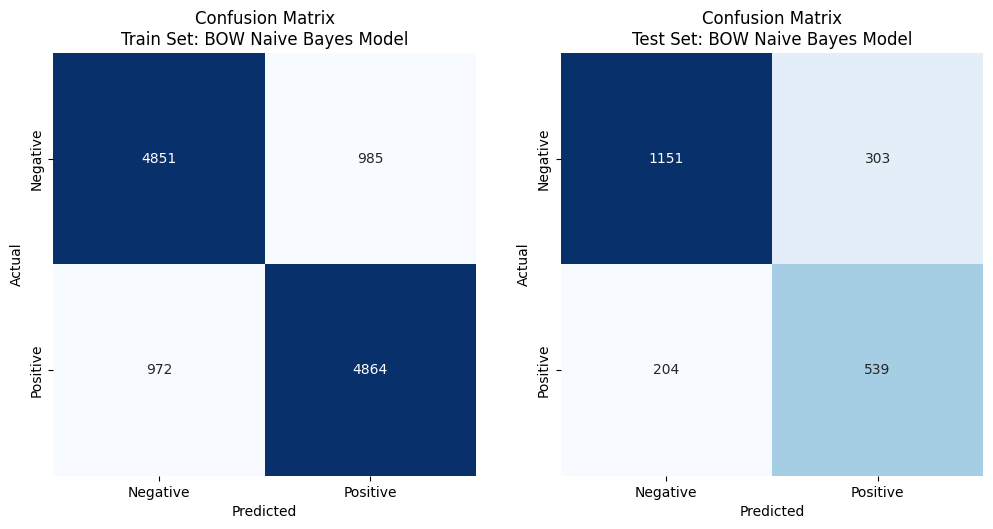

In [ ]:
# Compute confusion matrices
y_train_pred_btd = bayes_td.predict(X_train_resampled_td)
conf_matrix_train_btd = confusion_matrix(y_train_resampled, y_train_pred_btd)
conf_matrix_test_btd = confusion_matrix(y_test, y_test_pred_btd)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# First heatmap for Train Set
sns.heatmap(conf_matrix_train_btd, annot=True, fmt='d', cmap='Blues', square=True,cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=[ 'Negative','Positive'], ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix\nTrain Set: BOW Naive Bayes Model')

# Second heatmap for Test Set
sns.heatmap(conf_matrix_test_btd, annot=True, fmt='d', cmap='Blues', square=True,cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=[ 'Negative','Positive'], ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix\nTest Set: BOW Naive Bayes Model');

### Saving BOW Logistic and Bayes Results

In [ ]:
td_model = ['Logistic','Naive Bayes']
td_features = ['BOW','BOW']
td_trainingtime = [logistic_td_tt,bayes_td_tt]
td_train_acc = [mean_acc_ltd,mean_acc_btd]
td_test_acc = [test_acc_ltd,test_acc_btd]

td_metrics = pd.DataFrame({
    'Model': td_model,
    'Features': td_features,
    'Test Accuracy': td_test_acc,
    'Train Accuracy': td_train_acc,
    'Training Time': td_trainingtime
})

import pickle

# Save the entire dictionary to a pickle file
with open('td_model.pickle', 'wb') as file:
    pickle.dump(td_metrics, file)

In [ ]:
td_model_auc_data = {
    'Logistic-BOW': {'fpr': fpr_ltd, 'tpr': tpr_ltd, 'auc_score': auc_score_ltd},
    'Naive Bayes-BOW': {'fpr': fpr_btd, 'tpr': tpr_btd, 'auc_score': auc_score_btd},
}

# Save to a pickle file
with open('td_model_auc_data.pickle', 'wb') as file:
    pickle.dump(td_model_auc_data, file)

In [ ]:
td_model_score_data = {
    'Logistic\nBOW': {'precision': precision_ltd, 'recall': recall_ltd, 'auc_score': auc_score_ltd, 'F1-Score': f1_ltd},
    'Naive Bayes\nBOW': {'precision': precision_btd, 'recall': recall_btd, 'auc_score': auc_score_btd, 'F1-Score': f1_btd}
}
# Save to a pickle file
with open('td_model_score_data.pickle', 'wb') as file:
    pickle.dump(td_model_score_data, file)

### KNN - BOW


In [ ]:
k_values = list(range(1, 20))

cv_scores_td = []

start_time_knn = time.time()

for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_model, X_train_resampled_td, y_train_resampled, cv=10)
    cv_scores_td.append(scores.mean())

end_time_knn = time.time()
knn_tt_td1 = end_time_knn - start_time_knn

K vs Accuracy Curve: looking for the k that minimizes error


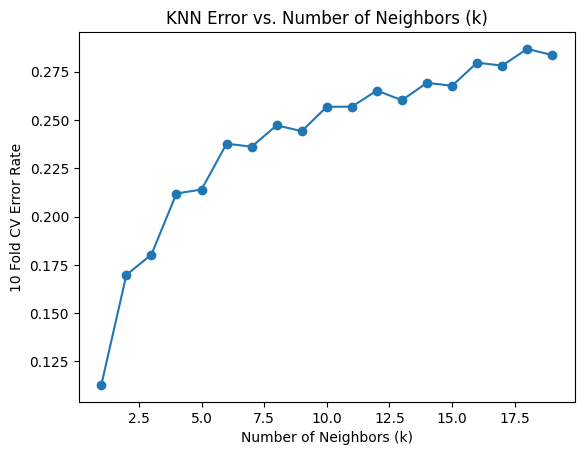

Optimal K: 1


In [ ]:
errors_td = [(1-i) for i in cv_scores_td]

figsize=(12, 6)
plt.plot(k_values, errors_td, marker='o')
plt.title('KNN Error vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('10 Fold CV Error Rate')
plt.show()

# Find the optimal k with the highest accuracy
optimal_k_td = k_values[errors_td.index(min(errors_td))]
print(f"Optimal K: {optimal_k_td}")

In [ ]:
knn_td = KNeighborsClassifier(n_neighbors=optimal_k_td)
start_time_knn = time.time()
knn_10fold_td = cross_val_score(knn_td, X_train_resampled_td, y_train_resampled, cv=10)
knn_td.fit(X_train_resampled_td, y_train_resampled)
end_time_knn = time.time()

# Computing Training Duration
knn_tt_td = (end_time_knn - start_time_knn) + knn_tt_td1
print(f"Training Duration: {knn_tt_td} Seconds")

mean_acc_knntd = knn_10fold_td.mean()
print(f"10-Fold Cross-Validation Accuracy: {mean_acc_knntd:.2%}")

Training Duration: 584.1901562213898 Seconds

10-Fold Cross-Validation Accuracy: 88.72%


In [ ]:
# Predict on train and test datasets
y_test_pred_knn_td = knn_td.predict(X_test_td)

# Test Accuracy
test_acc_knn_td = accuracy_score(y_test, y_test_pred_knn_td)
print(f"Test Accuracy: {test_acc_knn_td:.2%}")

# Compute test probabilities, false positive rate, true positive rate, and auc
y_test_prob_knn_td = knn_td.predict_proba(X_test_td)[:, 1]  # Probability of class 1 (positive)
fpr_knn_td, tpr_knn_td, threshold_knn_td = roc_curve(y_test, y_test_prob_knn_td)
auc_score_knn_td = roc_auc_score(y_test, y_test_prob_knn_td)
precision_knn_td, recall_knn_td, f1_knn_td, _ = precision_recall_fscore_support(y_test, y_test_pred_knn_td)
print(f"AUC Score: {auc_score_knn_td:.2%}")
print(f"Precision: {precision_knn_td[1]:.2%}")
print(f"Recall: {recall_knn_td[1]:.2%}")
print(f"F1-Score: {f1_knn_td[1]:.2%}")

Test Accuracy: 77.38%

AUC Score: 73.93%

Precision: 67.72%

Recall: 63.26%

F1-Score: 65.41%


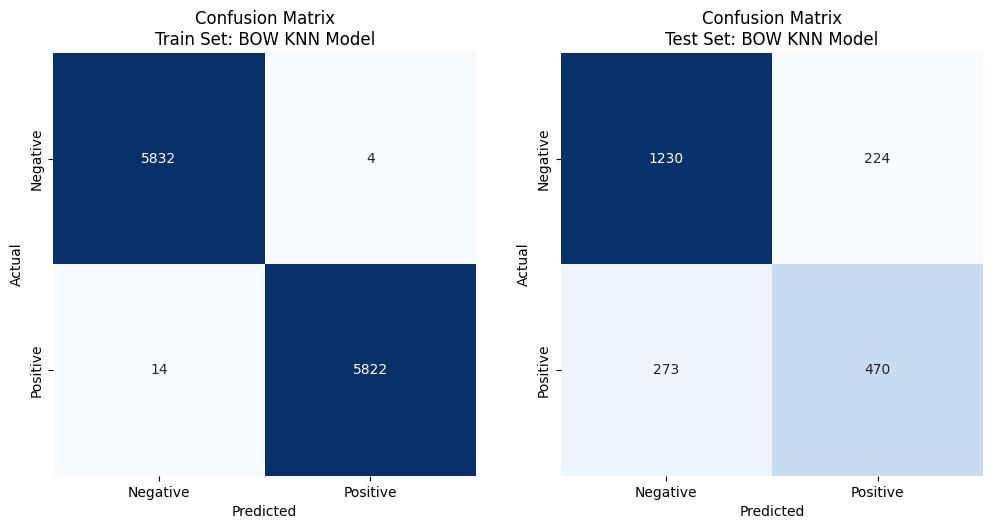

In [ ]:
# Compute confusion matrices
y_train_pred_knn_td = knn_td.predict(X_train_resampled_td)
conf_matrix_train_knn_td = confusion_matrix(y_train_resampled, y_train_pred_knn_td)
conf_matrix_test_knn_td = confusion_matrix(y_test, y_test_pred_knn_td)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# First heatmap for Train Set
sns.heatmap(conf_matrix_train_knn_td, annot=True, fmt='d', cmap='Blues', square=True, cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix\nTrain Set: BOW KNN Model')

# Second heatmap for Test Set
sns.heatmap(conf_matrix_test_knn_td, annot=True, fmt='d', cmap='Blues', square=True, cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix\nTest Set: BOW KNN Model')

plt.show()

#### Save BOW KNN Results

In [ ]:
knntd_model = ['KNN']
knntd_features = ['BOW']
knntd_trainingtime = [knn_tt_td]
knntd_train_acc = [mean_acc_knntd]
knntd_test_acc = [test_acc_knn_td]

knntd_metrics = pd.DataFrame({
    'Model': knntd_model,
    'Features': knntd_features,
    'Test Accuracy': knntd_test_acc,
    'Train Accuracy': knntd_train_acc,
    'Training Time': knntd_trainingtime
})

import pickle

# Save the KNN-related metrics to a pickle file
with open('knntd_model.pickle', 'wb') as file:
    pickle.dump(knntd_metrics, file)

In [ ]:
knntd_model_auc_data = {
    'KNN-BOW': {'fpr': fpr_knn_td, 'tpr': tpr_knn_td, 'auc_score': auc_score_knn_td},
}

# Save to a pickle file
with open('knntd_model_auc_data.pickle', 'wb') as file:
    pickle.dump(knntd_model_auc_data, file)


In [ ]:
knntd_model_score_data = {
    'KNN\nBOW': {'precision': precision_knn_td, 'recall': recall_knn_td, 'auc_score': auc_score_knn_td, 'F1-Score': f1_knn_td},
}

# Save to a pickle file
with open('knntd_model_score_data.pickle', 'wb') as file:
    pickle.dump(knntd_model_score_data, file)


### Random Forest - BOW

Training Random Forest with 10-Fold CV

In [ ]:
def objective(trial):
    param_dist = {
        'n_estimators': trial.suggest_int('n_estimators', 50,500),
        'max_features': trial.suggest_categorical('max_features', ['sqrt',None]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2,20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1,20)
    }

    rf_td = RandomForestClassifier(criterion='entropy', random_state=42, **param_dist)
    cv_scores = cross_val_score(rf_td, X_train_resampled_td, y_train_resampled, cv=3,n_jobs=-1)

    return cv_scores.mean()

In [ ]:
start_time = time.time() # record time
study_rftd = optuna.create_study(direction='maximize')
study_rftd.optimize(objective, n_trials=5)
end_time = time.time() # record time

[I 2023-12-07 02:24:40,455] A new study created in memory with name: no-name-3b278053-b80e-4b04-890e-ef964d2cf585

[I 2023-12-07 02:25:37,799] Trial 0 finished with value: 0.8979632430165894 and parameters: {'n_estimators': 173, 'max_features': 'sqrt', 'min_samples_split': 20, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8979632430165894.

[I 2023-12-07 02:26:45,218] Trial 1 finished with value: 0.8190546505382205 and parameters: {'n_estimators': 410, 'max_features': 'sqrt', 'min_samples_split': 18, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8979632430165894.

[I 2023-12-07 02:27:37,525] Trial 2 finished with value: 0.8415878754324405 and parameters: {'n_estimators': 240, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8979632430165894.

[I 2023-12-07 03:05:01,201] Trial 3 finished with value: 0.8395313862302146 and parameters: {'n_estimators': 318, 'max_features': None, 'min_samples_split': 8, 'min_samples_leaf

In [ ]:
#Computing Training Duration
rf_td_tt1 = end_time - start_time
print(f"Training Duration: {rf_td_tt1} Seconds")
print("Best Hyperparameters:", study_rftd.best_trial.params)
mean_acc_rftd = study_rftd.best_value
print(f"10-Fold Cross-Validation Accuracy: {mean_acc_rftd}")

Training Duration: 2493.523357629776 Seconds

Best Hyperparameters: {'n_estimators': 173, 'max_features': 'sqrt', 'min_samples_split': 20, 'min_samples_leaf': 1}

10-Fold Cross-Validation Accuracy: 0.8979632430165894


In [ ]:
start_time = time.time()
# Fitting the Random Forest
rf_td = RandomForestClassifier(criterion='entropy',**study_rftd.best_trial.params, random_state=42)
rf_td.fit(X_train_resampled_td, y_train_resampled)
end_time = time.time()
# Computing Train Time
rf_td_tt = (end_time - start_time) + rf_td_tt1
print(f"Training Duration: {rf_td_tt} Seconds")

Training Duration: 2517.7810020446777 Seconds


Predicting on Test Set

In [ ]:
# Predict on train and test datasets
y_test_pred_rftd = rf_td.predict(X_test_td)

#Test Accuracy
test_acc_rftd = accuracy_score(y_test, y_test_pred_rftd)
print(f"Test Accuracy: {test_acc_rftd:.2%}")

Test Accuracy: 82.66%


In [ ]:
# Compute test probabilities, false positive rate, true positive rate, and auc
y_test_prob_rftd = bayes_td.predict_proba(X_test_td)[:, 1]  # Probability of class 1 (positive)
fpr_rftd, tpr_rftd, threshold_rftd = roc_curve(y_test,y_test_prob_rftd)
auc_score_rftd = roc_auc_score(y_test, y_test_prob_rftd)
precision_rftd, recall_rftd, f1_rftd, _ = precision_recall_fscore_support(y_test, y_test_pred_rftd)
print(f"AUC Score: {auc_score_rftd:.2%}")
print(f"Precision: {precision_rftd[1]:.2%}")
print(f"Recall: {recall_rftd[1]:.2%}")
print(f"F1-Score: {f1_rftd[1]:.2%}")

AUC Score: 81.74%

Precision: 79.67%

Recall: 65.41%

F1-Score: 71.84%


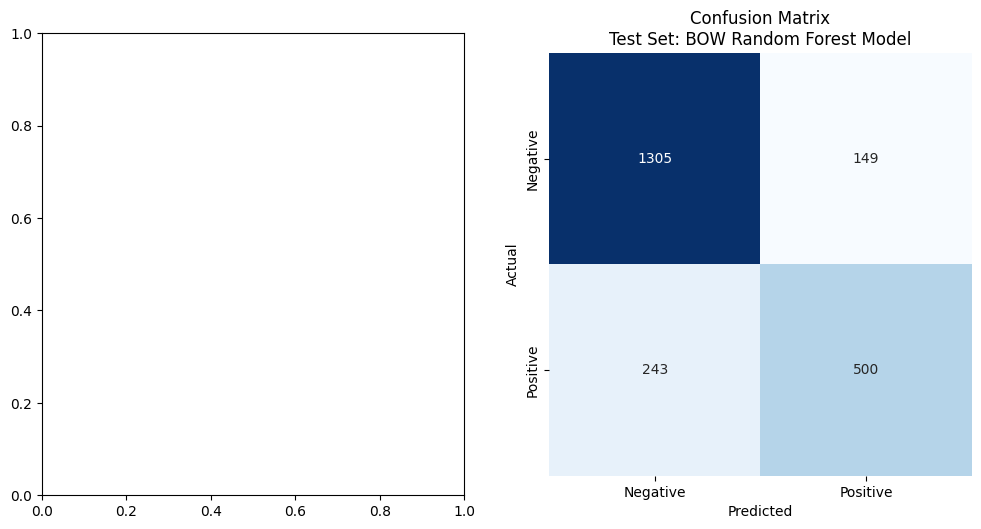

In [ ]:
#Compute confusion matrices
conf_matrix_test_rftd = confusion_matrix(y_test, y_test_pred_rftd)

figsize=(12, 6)
sns.heatmap(conf_matrix_test_rftd, annot=True, fmt='d', cmap='Blues', square=True,cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=[ 'Negative','Positive'], ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix\nTest Set: BOW Random Forest Model');

In [ ]:
# Feature Importance for Random Forest
features_td = vectorizer.get_feature_names_out()

feature_importances_rftd = pd.Series(rf_td.feature_importances_, index=features_td)
top_n = 10
top_features_rftd = feature_importances_rftd.nlargest(top_n)

print(f"\nTop {top_n} Feature Importances (Random Forest):")
print(top_features_rftd)



Top 10 Feature Importances (Random Forest):

diploma        0.005516

school         0.005224

business       0.004848

equipment      0.004747

development    0.003998

shift          0.003971

management     0.003950

senior         0.003725

lift           0.003722

duty           0.003457

dtype: float64


### Gradient Boosting - BOW

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
def objective(trial):
    param_dist = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        }

    gbm_td = GradientBoostingClassifier(random_state=42, **param_dist)
    cv_scores = cross_val_score(gbm_td, X_train_resampled_td, y_train_resampled, cv=3, n_jobs = -1)

    return cv_scores.mean()

In [ ]:
start_time = time.time()
study_gbm_td = optuna.create_study(direction='maximize', pruner = optuna.pruners.SuccessiveHalvingPruner())
study_gbm_td.optimize(objective, n_trials=3, n_jobs =-1)
end_time = time.time()

[I 2023-12-07 17:35:14,508] A new study created in memory with name: no-name-618e3e17-d3c4-4cd6-a759-6a1c416fbec0

[I 2023-12-07 17:41:35,561] Trial 0 finished with value: 0.8947931387375387 and parameters: {'n_estimators': 162, 'learning_rate': 0.2636503619506562, 'max_depth': 7, 'subsample': 0.8404334922204837, 'min_samples_split': 20, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8947931387375387.


In [ ]:
gbm_td_tt1 = end_time - start_time # Tuning Duration
print(f"Training Duration: {gbm_td_tt1} Seconds")
print("Best Hyperparameters:", study_gbm_td.best_trial.params)
mean_acc_gbmtd = study_gbm_td.best_value
print(f"10-Fold Cross-Validation Accuracy: {mean_acc_gbmtd}")

Training Duration: 381.0585310459137 Seconds

Best Hyperparameters: {'n_estimators': 162, 'learning_rate': 0.2636503619506562, 'max_depth': 7, 'subsample': 0.8404334922204837, 'min_samples_split': 20, 'min_samples_leaf': 1}

10-Fold Cross-Validation Accuracy: 0.8947931387375387


In [ ]:
# Best model from hyperparameter tuning
start_time = time.time()
gbm_td = GradientBoostingClassifier(random_state=42, **study_gbm_td.best_trial.params)
gbm_td.fit(X_train_resampled_td, y_train_resampled)
end_time = time.time()
gbm_td_tt = (end_time - start_time) +  gbm_td_tt1 # Total Duration

Predicting on test set

In [ ]:
# Predict on train and test datasets
y_test_pred_gbmtd = gbm_td.predict(X_test_td)

#Test Accuracy
test_acc_gbmtd = accuracy_score(y_test, y_test_pred_gbmtd)
print(f"Test Accuracy: {test_acc_gbmtd:.2%}")

# Compute test probabilities, false positive rate, true positive rate, and auc
y_test_prob_gbmtd = gbm_td.predict_proba(X_test_td)[:, 1]  # Probability of class 1 (positive)
fpr_gbmtd, tpr_gbmtd, threshold_gbmtd = roc_curve(y_test,y_test_prob_gbmtd)
auc_score_gbmtd = roc_auc_score(y_test, y_test_prob_gbmtd)
precision_gbmtd, recall_gbmtd, f1_gbmtd, _ = precision_recall_fscore_support(y_test, y_test_pred_gbmtd)
print(f"AUC Score: {auc_score_gbmtd:.2%}")
print(f"Precision: {precision_gbmtd[1]:.2%}")
print(f"Recall: {recall_gbmtd[1]:.2%}")
print(f"F1-Score: {f1_gbmtd[1]:.2%}")

Test Accuracy: 82.20%

AUC Score: 88.46%

Precision: 74.04%

Recall: 72.95%

F1-Score: 73.49%


Compute confusion matrices


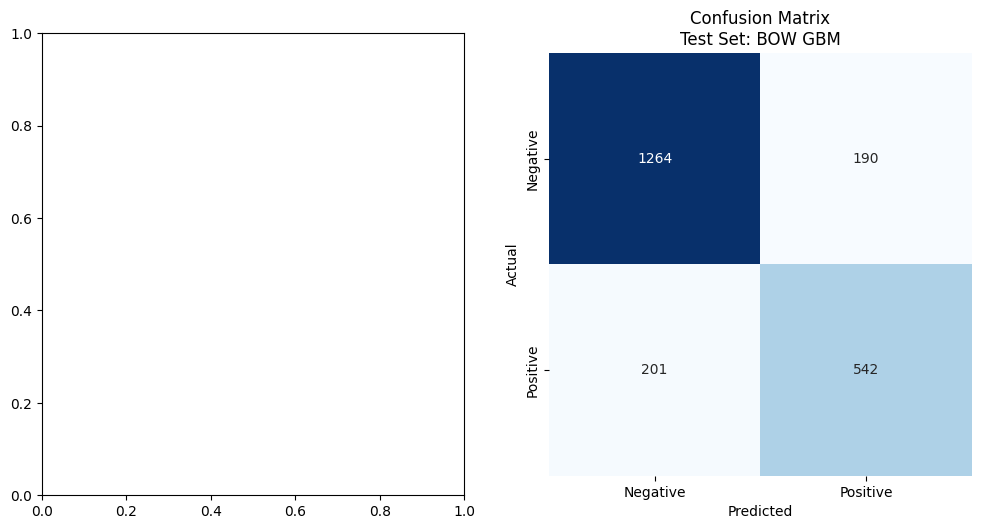

In [ ]:
conf_matrix_test_gbmtd = confusion_matrix(y_test, y_test_pred_gbmtd)
# Heatmap for Test Set
figsize=(12, 6)
sns.heatmap(conf_matrix_test_gbmtd, annot=True, fmt='d', cmap='Blues', square=True,cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=[ 'Negative','Positive'], ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix\nTest Set: BOW GBM');

Feature Importance for Random Forest


In [ ]:
# Feature Importance for Random Forest
features_td = vectorizer.get_feature_names_out()

feature_importances_gbmtd = pd.Series(gbm_td.feature_importances_, index=features_td)
top_n = 10
top_features_gbmtd = feature_importances_gbmtd.nlargest(top_n)

print(f"\nTop {top_n} Feature Importances (Random Forest):")
print(top_features_gbmtd)



Top 10 Feature Importances (Random Forest):

school        0.040155

safety        0.023540

business      0.018460

diploma       0.016420

manager       0.014820

leadership    0.013948

degree        0.011698

equipment     0.011293

employment    0.010781

senior        0.010552

dtype: float64


### Logistic Regression TF-IDF

In [ ]:
def objective(trial):

    C_value = trial.suggest_float('C', 1e-4, 1e4, log=True)  # Log-uniform distribution for C

    logistic_tfidf = LogisticRegression(C=C_value, penalty='l1', solver='liblinear', max_iter=1000)
    logistic_tfidf_cv_scores = cross_val_score(logistic_tfidf, X_train_resampled_tfidf , y_train_resampled, cv=10, scoring='accuracy',n_jobs=-1)

    return logistic_tfidf_cv_scores.mean()

In [ ]:
start_time = time.time() # record time
study_ltfidf = optuna.create_study(direction='maximize')
study_ltfidf.optimize(objective, n_trials=10)
end_time = time.time() # record time

[I 2023-12-07 19:26:48,852] A new study created in memory with name: no-name-b54472a2-fa36-4be8-ac4e-9812c77d752a

[I 2023-12-07 19:26:54,957] Trial 0 finished with value: 0.7698769529645151 and parameters: {'C': 0.4443225358779792}. Best is trial 0 with value: 0.7698769529645151.

[I 2023-12-07 19:27:10,048] Trial 1 finished with value: 0.8977940011268796 and parameters: {'C': 1015.1683965969726}. Best is trial 1 with value: 0.8977940011268796.

[I 2023-12-07 19:27:11,182] Trial 2 finished with value: 0.5 and parameters: {'C': 0.0002007243745463488}. Best is trial 1 with value: 0.8977940011268796.

[I 2023-12-07 19:27:12,321] Trial 3 finished with value: 0.5 and parameters: {'C': 0.0003054685473309508}. Best is trial 1 with value: 0.8977940011268796.

[I 2023-12-07 19:27:14,318] Trial 4 finished with value: 0.5523460518129849 and parameters: {'C': 0.02132449412876001}. Best is trial 1 with value: 0.8977940011268796.

[I 2023-12-07 19:27:22,081] Trial 5 finished with value: 0.819313806

In [ ]:
# Computing Training Duration
logistic_tfidf_tt = end_time - start_time
print(f"Train Time: {logistic_tfidf_tt} Seconds")

best_params_ltfidf = study_ltfidf.best_trial.params
print(f"Best Hyperparameters: {best_params_ltfidf}")

mean_acc_ltfidf = study_ltfidf.best_value
print(f"Best 10-Fold CV Accuracy: {mean_acc_ltfidf:.2%}")

Train Time: 66.75826168060303 Seconds

Best Hyperparameters: {'C': 1015.1683965969726}

Best 10-Fold CV Accuracy: 89.78%


In [ ]:
logistic_tfidf = LogisticRegression(C=best_params_ltfidf['C'], penalty='l1', solver='liblinear', max_iter=1000)
logistic_tfidf.fit(X_train_resampled_tfidf, y_train_resampled)

# Predict on train and test datasets
y_test_pred_ltfidf = logistic_tfidf.predict(X_test_tfidf)

#Test Accuracy
test_acc_ltfidf = accuracy_score(y_test, y_test_pred_ltfidf)
print(f"Test Accuracy: {test_acc_ltfidf:.2%}")

Test Accuracy: 79.47%


In [ ]:
# Compute test probabilities, false positive rate, true positive rate, and auc
y_test_prob_ltfidf = logistic_tfidf.predict_proba(X_test_tfidf)[:, 1]  # Probability of class 1 (positive)
fpr_ltfidf, tpr_ltfidf, threshold_ltfidf = roc_curve(y_test,y_test_prob_ltfidf)
auc_score_ltfidf = roc_auc_score(y_test, y_test_prob_ltfidf)
precision_ltfidf, recall_ltfidf, f1_ltfidf, _ = precision_recall_fscore_support(y_test, y_test_pred_ltfidf)
print(f"AUC Score: {auc_score_ltfidf:.2%}")
print(f"Precision: {precision_ltfidf[1]:.2%}")
print(f"Recall: {recall_ltfidf[1]:.2%}")
print(f"F1-Score: {f1_ltfidf[1]:.2%}")

AUC Score: 83.54%

Precision: 69.52%

Recall: 69.99%

F1-Score: 69.75%


In [ ]:
# Get the coefficient weights and corresponding features
coef_weights_test_tfidf = logistic_tfidf.coef_.flatten()
features_tfidf = tfidf_vectorizer.get_feature_names_out()

coef_df = pd.DataFrame({'Feature': features_tfidf, 'Coefficient': coef_weights_test_tfidf})
top10_coef_tfidf = coef_df.nlargest(10, 'Coefficient')

# Top 10 features and their coefficient weights
print("Top 10 Coefficient Weights on Test Data:")
print(top10_coef_tfidf)

Top 10 Coefficient Weights on Test Data:

                 Feature  Coefficient

20653   functionsgeneral   124.697249

45438                sar   118.692255

29107      manageragency   116.795862

1872         alternating   103.285167

11926                cut    94.753575

19179  feasibilityensure    88.548910

40512            provost    88.056306

1965             amentum    83.870774

19834              float    83.461099

50882  systemproficiency    83.376080


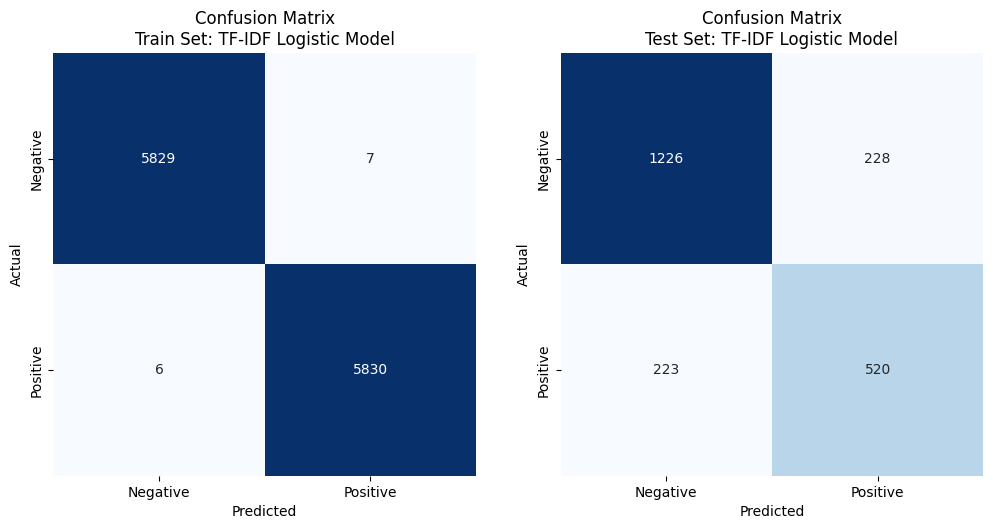

In [ ]:
# Compute confusion matrices
y_train_pred_ltfidf = logistic_tfidf.predict(X_train_resampled_tfidf)
conf_matrix_train_ltfidf = confusion_matrix(y_train_resampled, y_train_pred_ltfidf)
conf_matrix_test_ltfidf = confusion_matrix(y_test, y_test_pred_ltfidf)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# First heatmap for Train Set
sns.heatmap(conf_matrix_train_ltfidf, annot=True, fmt='d', cmap='Blues', square=True,cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix\nTrain Set: TF-IDF Logistic Model')

# Second heatmap for Test Set
sns.heatmap(conf_matrix_test_ltfidf, annot=True, fmt='d', cmap='Blues', square=True,cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix\nTest Set: TF-IDF Logistic Model');

### Naive Bayes - TF-IDF


10-Fold CV Training

In [ ]:
start_time = time.time()
# Fitting the Naive Bayes model
bayes_tfidf = MultinomialNB()
# Preforming 10-Fold CV
bayes_tfidf_10fold = cross_val_score(bayes_tfidf,X_train_resampled_tfidf, y_train_resampled, cv=10)
end_time = time.time()
# Computing Train Time
bayes_tfidf_tt = end_time - start_time
print(f"Training Duration: {bayes_tfidf_tt} Seconds")

mean_acc_btfidf = bayes_tfidf_10fold.mean()
print(f"10-Fold Cross-Validation Accuracy: {mean_acc_btfidf}")

Training Duration: 0.37563252449035645 Seconds

10-Fold Cross-Validation Accuracy: 0.7853848264488034


Predicting on test set

In [ ]:
bayes_tfidf.fit(X_train_resampled_tfidf, y_train_resampled)
# Predict on train and test datasets
y_test_pred_btfidf = bayes_tfidf.predict(X_test_tfidf)

#Test Accuracy
test_acc_btfidf = accuracy_score(y_test, y_test_pred_btfidf)
print(f"Test Accuracy: {test_acc_btfidf:.2%}")

Test Accuracy: 75.56%


In [ ]:
# Compute test probabilities, false positive rate, true positive rate, and auc
y_test_prob_btfidf = bayes_tfidf.predict_proba(X_test_tfidf)[:, 1]  # Probability of class 1 (positive)
fpr_btfidf, tpr_btfidf, threshold_btfidf = roc_curve(y_test,y_test_prob_btfidf)
auc_score_btfidf = roc_auc_score(y_test, y_test_prob_btfidf)
precision_btfidf, recall_btfidf, f1_btfidf, _ = precision_recall_fscore_support(y_test, y_test_pred_btfidf)
print(f"AUC Score: {auc_score_btfidf:.2%}")
print(f"Precision: {precision_btfidf[1]:.2%}")
print(f"Recall: {recall_btfidf[1]:.2%}")
print(f"F1-Score: {f1_btfidf[1]:.2%}")

AUC Score: 83.88%

Precision: 61.52%

Recall: 74.02%

F1-Score: 67.20%


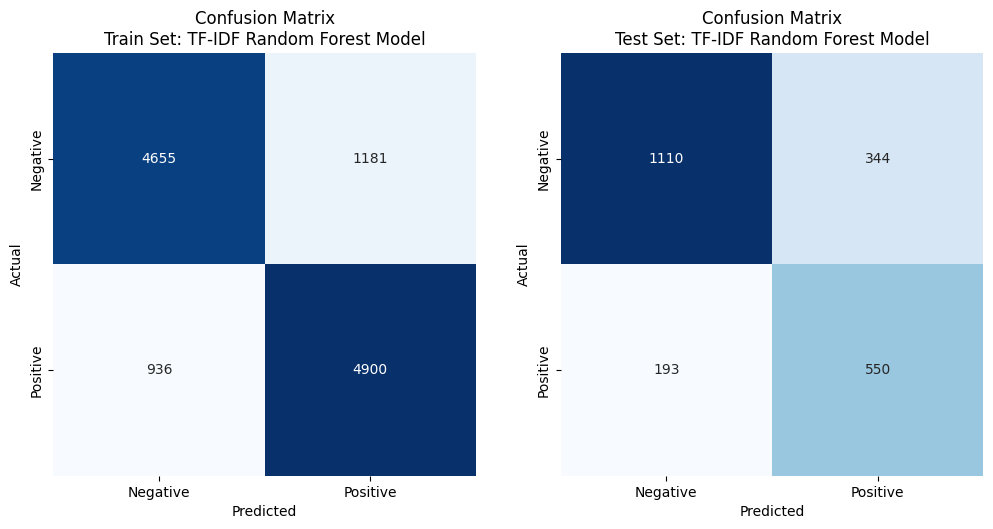

In [ ]:
# Compute confusion matrices
y_train_pred_btfidf = bayes_tfidf.predict(X_train_resampled_tfidf)
conf_matrix_train_btfidf = confusion_matrix(y_train_resampled, y_train_pred_btfidf)
conf_matrix_test_btfidf = confusion_matrix(y_test, y_test_pred_btfidf)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# First heatmap for Train Set
sns.heatmap(conf_matrix_train_btfidf, annot=True, fmt='d', cmap='Blues', square=True,cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=[ 'Negative','Positive'], ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix\nTrain Set: TF-IDF Random Forest Model')

# Second heatmap for Test Set
sns.heatmap(conf_matrix_test_btfidf, annot=True, fmt='d', cmap='Blues', square=True,cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=[ 'Negative','Positive'], ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix\nTest Set: TF-IDF Random Forest Model');

### Save Results

In [ ]:
tfidf_model = ['Logistic','Naive Bayes']
tfidf_features = ['TF-IDF','TF-IDF']
tfidf_trainingtime = [logistic_tfidf_tt,bayes_tfidf_tt]
tfidf_train_acc = [mean_acc_ltfidf,mean_acc_btfidf]
tfidf_test_acc = [test_acc_ltfidf,test_acc_btfidf]

tfidf_metrics = pd.DataFrame({
    'Model': tfidf_model,
    'Features': tfidf_features,
    'Test Accuracy': tfidf_test_acc,
    'Train Accuracy': tfidf_train_acc,
    'Training Time': tfidf_trainingtime
})

import pickle

# Save the entire dictionary to a pickle file
with open('tfidf_model.pickle', 'wb') as file:
    pickle.dump(tfidf_metrics, file)

In [ ]:
tfidf_model_auc_data = {
    'Logistic-TF-IDF': {'fpr': fpr_ltfidf, 'tpr': tpr_ltfidf, 'auc_score': auc_score_ltfidf},
    'Naive Bayes-TF-IDF': {'fpr': fpr_btfidf, 'tpr': tpr_btfidf, 'auc_score': auc_score_btfidf},
}

# Save to a pickle file
with open('tfidf_model_auc_data.pickle', 'wb') as file:
    pickle.dump(tfidf_model_auc_data, file)

In [ ]:
tfidf_model_score_data = {
    'Logistic\nTF-IDF': {'precision': precision_ltfidf, 'recall': recall_ltfidf, 'auc_score': auc_score_ltfidf, 'F1-Score': f1_ltfidf},
    'Naive Bayes\nTF-IDF': {'precision': precision_btfidf, 'recall': recall_btfidf, 'auc_score': auc_score_btfidf, 'F1-Score': f1_btfidf}
}
# Save to a pickle file
with open('tfidf_model_score_data.pickle', 'wb') as file:
    pickle.dump(tfidf_model_score_data, file)

### KNN - TF-IDF


K vs Accuracy Curve: looking for the k that minimizes error


In [ ]:
# Train the KNN model with the optimal k value
knn_tfidf = KNeighborsClassifier(n_neighbors=1)
start_time_knn = time.time()
knn_10fold_tfidf = cross_val_score(knn_tfidf, X_train_resampled_tfidf, y_train_resampled, cv=3, n_jobs=-1)
knn_tfidf.fit(X_train_resampled_tfidf, y_train_resampled)
end_time_knn = time.time()

# Computing Training Duration
knn_tt_tfidf = (end_time_knn - start_time_knn) + knn_tt_td1
print(f"Training Duration: {knn_tt_tfidf} Seconds")

mean_acc_knn_tfidf = knn_10fold_tfidf.mean()
print(f"10-Fold Cross-Validation Accuracy: {mean_acc_knn_tfidf:.2%}")

Training Duration: 5085.525923252106 Seconds

10-Fold Cross-Validation Accuracy: 86.33%


In [ ]:
# Predict on the test dataset
y_test_pred_knn_tfidf = knn_tfidf.predict(X_test_tfidf)

# Test Accuracy
test_acc_knn_tfidf = accuracy_score(y_test, y_test_pred_knn_tfidf)
print(f"Test Accuracy: {test_acc_knn_tfidf:.2%}")

# Compute test probabilities, false positive rate, true positive rate, and auc
y_test_prob_knn_tfidf = knn_tfidf.predict_proba(X_test_tfidf)[:, 1]  # Probability of class 1 (positive)
fpr_knn_tfidf, tpr_knn_tfidf, threshold_knn_tfidf = roc_curve(y_test, y_test_prob_knn_tfidf)
auc_score_knn_tfidf = roc_auc_score(y_test, y_test_prob_knn_tfidf)
precision_knn_tfidf, recall_knn_tfidf, f1_knn_tfidf, _ = precision_recall_fscore_support(y_test, y_test_pred_knn_tfidf)
print(f"AUC Score: {auc_score_knn_tfidf:.2%}")
print(f"Precision: {precision_knn_tfidf[1]:.2%}")
print(f"Recall: {recall_knn_tfidf[1]:.2%}")
print(f"F1-Score: {f1_knn_tfidf[1]:.2%}")

Test Accuracy: 77.92%

AUC Score: 75.23%

Precision: 67.53%

Recall: 66.89%

F1-Score: 67.21%


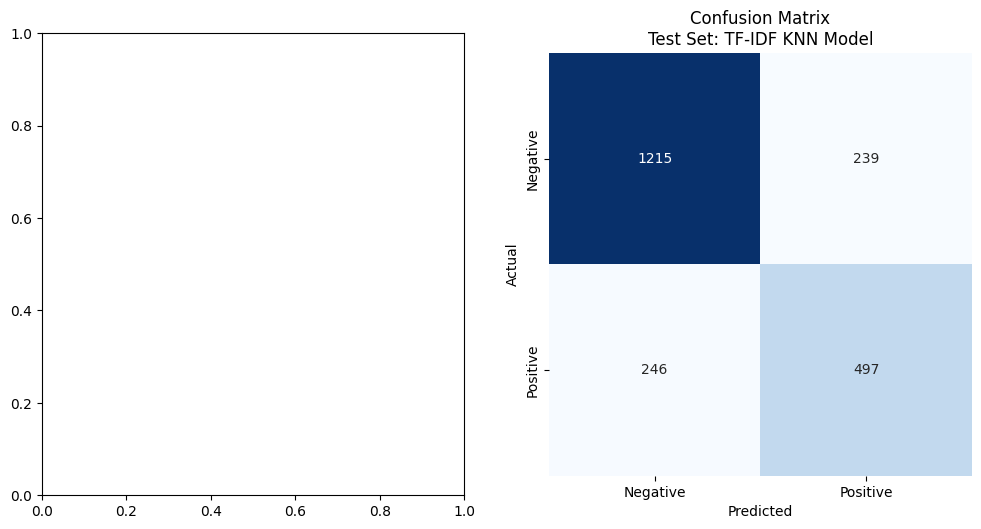

In [ ]:
# Compute confusion matrices
#y_train_pred_knn_tfidf = knn_tfidf.predict(X_train_resampled_tfidf)
#conf_matrix_train_knn_tfidf = confusion_matrix(y_train_resampled, y_train_pred_knn_tfidf)
conf_matrix_test_knn_tfidf = confusion_matrix(y_test, y_test_pred_knn_tfidf)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# # First heatmap for Train Set
# sns.heatmap(conf_matrix_train_knn_tfidf, annot=True, fmt='d', cmap='Blues', square=True, cbar=False,
#             xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=axes[0])
# axes[0].set_xlabel('Predicted')
# axes[0].set_ylabel('Actual')
# axes[0].set_title('Confusion Matrix\nTrain Set: TF-IDF KNN Model')

# Second heatmap for Test Set
sns.heatmap(conf_matrix_test_knn_tfidf, annot=True, fmt='d', cmap='Blues', square=True, cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix\nTest Set: TF-IDF KNN Model')

plt.show()

Save Results

In [ ]:
knntfidf_model = ['KNN']
knntfidf_features = ['TF-IDF']
knntfidf_trainingtime = [knn_tt_tfidf]
knntfidf_train_acc = [mean_acc_knn_tfidf]
knntfidf_test_acc = [test_acc_knn_tfidf]

knntfidf_metrics = pd.DataFrame({
    'Model': knntfidf_model,
    'Features': knntfidf_features,
    'Test Accuracy': knntfidf_test_acc,
    'Train Accuracy': knntfidf_train_acc,
    'Training Time': knntfidf_trainingtime
})

import pickle

# Save the KNN-related metrics to a pickle file
with open('knntfidf_model.pickle', 'wb') as file:
    pickle.dump(knntfidf_metrics, file)

knntfidf_model_auc_data = {
    'KNN-TF-IDF': {'fpr': fpr_knn_tfidf, 'tpr': tpr_knn_tfidf, 'auc_score': auc_score_knn_tfidf},
}

# Save to a pickle file
with open('knntfidf_model_auc_data.pickle', 'wb') as file:
    pickle.dump(knntfidf_model_auc_data, file)

knntfidf_model_score_data = {
    'KNN\nTF-IDF': {'precision': precision_knn_tfidf, 'recall': recall_knn_tfidf, 'auc_score': auc_score_knn_tfidf, 'F1-Score': f1_knn_tfidf},
}

# Save to a pickle file
with open('knntfidf_model_score_data.pickle', 'wb') as file:
    pickle.dump(knntfidf_model_score_data, file)

### Random Forest - TF-IDF

Training Random Forest with 10-Fold CV

In [ ]:
start_time = time.time()
# Fitting the Random Forest
rf_tfidf = RandomForestClassifier(criterion='entropy', random_state=42, **study_rftd.best_trial.params)
# Preforming 3-Fold CV
rf_tfidf_3fold = cross_val_score(rf_tfidf,X_train_resampled_tfidf, y_train_resampled, cv=3, n_jobs =-1)
rf_tfidf.fit(X_train_resampled_tfidf, y_train_resampled)
end_time = time.time()
# Computing Train Time
rf_tfidf_tt = (end_time - start_time) + rf_td_tt1
print(f"Training Duration: {rf_tfidf_tt} Seconds")

mean_acc_rftfidf = rf_tfidf_3fold.mean()
print(f"10-Fold Cross-Validation Accuracy: {mean_acc_rftfidf}")


Training Duration: 105.04751467704773 Seconds

10-Fold Cross-Validation Accuracy: 0.871917396879887


Predicting on Test Set

In [ ]:
# Predict on train and test datasets
y_test_pred_rftfidf = rf_tfidf.predict(X_test_tfidf)

#Test Accuracy
test_acc_rftfidf = accuracy_score(y_test, y_test_pred_rftfidf)
print(f"Test Accuracy: {test_acc_rftfidf:.2%}")

Test Accuracy: 82.39%


In [ ]:
# Compute test probabilities, false positive rate, true positive rate, and auc
y_test_prob_rftfidf = rf_tfidf.predict_proba(X_test_tfidf)[:, 1]  # Probability of class 1 (positive)
fpr_rftfidf, tpr_rftfidf, threshold_rftfidf = roc_curve(y_test,y_test_prob_rftfidf)
auc_score_rftfidf = roc_auc_score(y_test, y_test_prob_rftfidf)
precision_rftfidf, recall_rftfidf, f1_rftfidf, _ = precision_recall_fscore_support(y_test, y_test_pred_rftfidf)
print(f"AUC Score: {auc_score_rftfidf:.2%}")
print(f"Precision: {precision_rftfidf[1]:.2%}")
print(f"Recall: {recall_rftfidf[1]:.2%}")
print(f"F1-Score: {f1_rftfidf[1]:.2%}")

AUC Score: 88.62%

Precision: 78.53%

Recall: 65.95%

F1-Score: 71.69%


In [ ]:
# Compute confusion matrix
conf_matrix_test_rftfidf = confusion_matrix(y_test, y_test_pred_rftfidf)

figsize=(12, 6)
sns.heatmap(conf_matrix_test_rftfidf, annot=True, fmt='d', cmap='Blues', square=True,cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=[ 'Negative','Positive'], ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix\nTest Set: TF-IDF Random Forest Model');

In [ ]:
# Feature Importance for Random Forest
features_tfidf = tfidf_vectorizer.get_feature_names_out()

feature_importances_rftfidf = pd.Series(rf_tfidf.feature_importances_, index=features_tfidf)
top_n = 10
top_features_rftfidf = feature_importances_rftfidf.nlargest(top_n)

print(f"\nTop {top_n} Feature Importances (Random Forest):")
print(top_features_rftfidf)



Top 10 Feature Importances (Random Forest):

business       0.005456

school         0.004720

management     0.004465

equipment      0.004373

lead           0.004127

diploma        0.004121

leadership     0.003877

development    0.003601

year           0.003570

lift           0.003505

dtype: float64


### GBM - TF-IDF

Using the best hyperparameters from the TD Matrix because this one took way to long

In [ ]:
start_time = time.time()
# Fitting the Random Forest
gbm_tfidf = GradientBoostingClassifier(random_state=42, **study_gbm_td.best_trial.params)
# Preforming 3-Fold CV
gbm_tfidf_10fold = cross_val_score(gbm_tfidf,X_train_resampled_tfidf, y_train_resampled, cv=3)
end_time = time.time()

Training Duration: 1014.6226494312286 Seconds

10-Fold Cross-Validation Accuracy: 0.8941077304270594


In [ ]:
# Computing Train Time
gbm_tfidf_tt = (end_time - start_time) + gbm_td_tt1
print(f"Training Duration: {gbm_tfidf_tt} Seconds")

mean_acc_gbmtfidf = gbm_tfidf_10fold.mean()
print(f"10-Fold Cross-Validation Accuracy: {mean_acc_gbmtfidf}")

In [ ]:
gbm_tfidf.fit(X_train_resampled_tfidf, y_train_resampled)

GradientBoostingClassifier(learning_rate=0.2636503619506562, max_depth=7,
                           min_samples_split=20, n_estimators=162,
                           random_state=42, subsample=0.8404334922204837)

Fitting and Predicting on Test Set

In [ ]:
# Predict on train and test datasets
y_test_pred_gbmtfidf = gbm_tfidf.predict(X_test_tfidf)

#Test Accuracy
test_acc_gbmtfidf = accuracy_score(y_test, y_test_pred_gbmtfidf)
print(f"Test Accuracy: {test_acc_gbmtfidf:.2%}")

# Compute test probabilities, false positive rate, true positive rate, and auc
y_test_prob_gbmtfidf = gbm_tfidf.predict_proba(X_test_tfidf)[:, 1]  # Probability of class 1 (positive)
fpr_gbmtfidf, tpr_gbmtfidf, threshold_gbmtfidf = roc_curve(y_test,y_test_prob_gbmtfidf)
auc_score_gbmtfidf = roc_auc_score(y_test, y_test_prob_gbmtfidf)
precision_gbmtfidf, recall_gbmtfidf, f1_gbmtfidf, _ = precision_recall_fscore_support(y_test, y_test_pred_gbmtfidf)
print(f"AUC Score: {auc_score_gbmtfidf:.2%}")
print(f"Precision: {precision_gbmtfidf[1]:.2%}")
print(f"Recall: {recall_gbmtfidf[1]:.2%}")
print(f"F1-Score: {f1_gbmtfidf[1]:.2%}")

Test Accuracy: 81.88%

AUC Score: 88.19%

Precision: 74.61%

Recall: 70.39%

F1-Score: 72.44%


Confusion Matrix

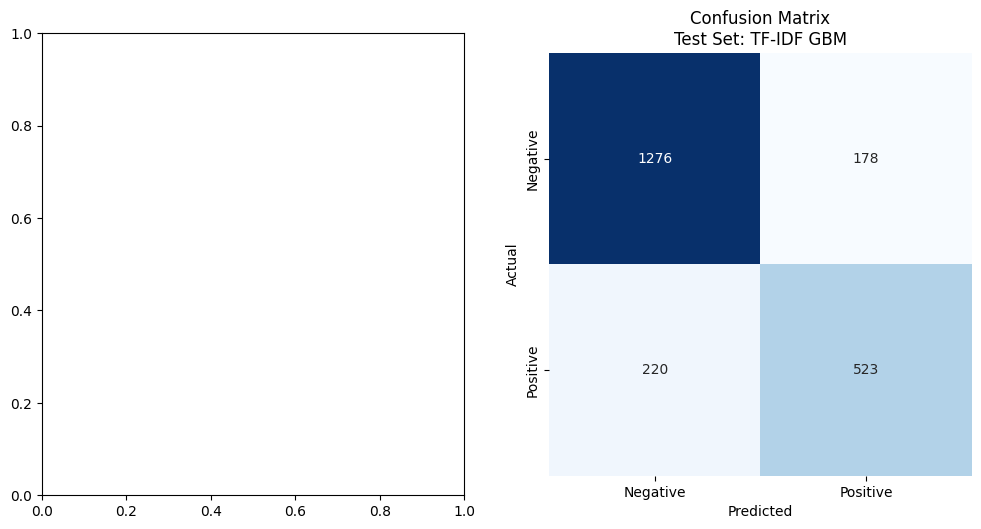

In [ ]:
conf_matrix_test_gbmtfidf = confusion_matrix(y_test, y_test_pred_gbmtfidf)
figsize=(12, 6)
sns.heatmap(conf_matrix_test_gbmtfidf, annot=True, fmt='d', cmap='Blues', square=True,cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=[ 'Negative','Positive'], ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix\nTest Set: TF-IDF GBM');

Feature Importance

In [ ]:
# Feature Importance for Random Forest
features_tfidf = vectorizer.get_feature_names_out()

feature_importances_gbmtfidf = pd.Series(gbm_tfidf.feature_importances_, index=features_tfidf)
top_n = 10
top_features_gbmtfidf = feature_importances_gbmtfidf.nlargest(top_n)

print(f"\nTop {top_n} Feature Importances (Random Forest):")
print(top_features_gbmtfidf)



Top 10 Feature Importances (Random Forest):

school        0.038843

business      0.026257

diploma       0.016147

lift          0.014155

management    0.013950

year          0.012883

leadership    0.011205

strategic     0.011157

safety        0.010979

senior        0.010712

dtype: float64


#### Save the RF and GBM results

In [ ]:
tree_models = ['Random Forest','GBM','Random Forest','GBM']
tree_features = ['BOW','BOW','TF-IDF','TF-IDF']
tree_trainingtime = [rf_td_tt, gbm_td_tt, rf_tfidf_tt, gbm_tfidf_tt]
tree_train_acc = [mean_acc_rftd, mean_acc_gbmtd, mean_acc_rftfidf, mean_acc_gbmtfidf]
tree_test_acc = [test_acc_rftd,test_acc_gbmtd, test_acc_rftfidf,test_acc_gbmtfidf]

tree_metrics = pd.DataFrame({
    'Model': tree_models,
    'Features': tree_features,
    'Test Accuracy': tree_test_acc,
    'Train Accuracy': tree_train_acc,
    'Training Time': tree_trainingtime
})

tree_metrics

import pickle

# Save the entire dictionary to a pickle file
with open('tree_metrics.pickle', 'wb') as file:
    pickle.dump(tree_metrics, file)

In [ ]:
# AUC data for different models and features
tree_model_auc_data = {
    'Random Forest-BOW': {'fpr': fpr_rftd, 'tpr': tpr_rftd, 'auc_score': auc_score_rftd},
    'Random Forest-TF-IDF': {'fpr': fpr_rftfidf, 'tpr': tpr_rftfidf, 'auc_score': auc_score_rftfidf},
    'GBM-BOW': {'fpr': fpr_gbmtd, 'tpr': tpr_gbmtd, 'auc_score': auc_score_gbmtd},
    'GBM-TF-IDF': {'fpr': fpr_gbmtfidf, 'tpr': tpr_gbmtfidf, 'auc_score': auc_score_gbmtfidf}
    }

# Save the entire dictionary to a pickle file
with open('tree_model_auc_data.pickle', 'wb') as file:
    pickle.dump(tree_model_auc_data, file)

tree_model_score_data = {
    'Random Forest\nBOW': {'precision': precision_rftd, 'recall': recall_rftd, 'auc_score': auc_score_rftd, 'F1-Score': f1_rftd},
    'Random Forest\nTF-IDF': {'precision': precision_rftfidf, 'recall': recall_rftfidf, 'auc_score': auc_score_rftfidf, 'F1-Score': f1_rftfidf},
    'GBM\nBOW': {'precision': precision_gbmtd, 'recall': recall_gbmtd, 'auc_score': auc_score_gbmtd, 'F1-Score': f1_gbmtd},
    'GBM\nTF-IDF': {'precision': precision_gbmtfidf, 'recall': recall_gbmtfidf, 'auc_score': auc_score_gbmtfidf, 'F1-Score': f1_gbmtfidf},
}

# Save the entire dictionary to a pickle file
with open('tree_model_score_data.pickle', 'wb') as file:
    pickle.dump(tree_model_score_data, file)